<a href="https://colab.research.google.com/github/aknn/Data-science/blob/master/Burgers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y deepxde && pip install deepxde matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 6.8 MB/s eta 0:00:00


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
Building feed-forward neural network...
'build' took 0.088804 s

'compile' took 0.477429 s

Training model...

Step      Train loss              Test loss               Test metric
0         [4.75e-02, 2.03e-02]    [4.75e-02, 2.03e-02]    []  
1000      [1.45e-06, 1.49e-07]    [1.45e-06, 1.49e-07]    []  
2000      [4.49e-07, 8.26e-08]    [4.49e-07, 8.26e-08]    []  
3000      [2.14e-07, 2.95e-08]    [2.14e-07, 2.95e-08]    []  
4000      [1.12e-07, 8.54e-09]    [1.12e-07, 8.54e-09]    []  
5000      [9.61e-06, 1.30e-05]    [9.61e-06, 1.30e-05]    []  
6000      [4.50e-08, 8.84e-09]    [4.50e-08, 8.84e-09]    []  
7000      [2.55e-08, 1.60e-09]    [2.55e-08, 1.60e-09]    []  
8000      [1.75e-08, 1.

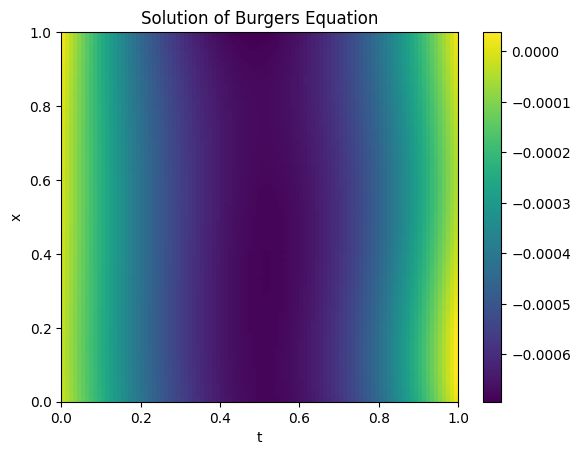

In [2]:
# prompt: Solve a simple 1D Burgers’ equation (a nonlinear PDE that appears in fluid mechanics and traffic flow) I am thinking PINN

import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Define the geometry and time domain
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the Burgers' equation
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

# Define the initial condition
def initial_condition(x):
    return -np.sin(np.pi * x)

# Define the boundary condition
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)

# Create the data
data = dde.data.TimePDE(geomtime, pde, [bc], num_domain=2540, num_boundary=80, num_initial=160)

# Define the neural network
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot uniform")

# Create the model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)

# Predict the solution
x = np.linspace(0, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
X_star = np.vstack((np.ravel(X), np.ravel(T))).T
y_star = model.predict(X_star)
Y_star = y_star.reshape(100, 100)

# Plot the solution
plt.figure()
plt.imshow(Y_star, interpolation='nearest', cmap='viridis',
            extent=[t.min(), t.max(), x.min(), x.max()],
            origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Solution of Burgers Equation')
plt.show()
